# Import libs

In [987]:
# Data manipulation
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
# Plots
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 1.5
%matplotlib inline

# Warnings configuration
# ==============================================================================
import warnings

# Modeling and Forecasting
# ==============================================================================
from catboost import CatBoostRegressor
from joblib import dump, load
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import \
    ForecasterAutoregMultiOutput
from skforecast.model_selection import (backtesting_forecaster,
                                        grid_search_forecaster)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.auto import tqdm
from tsfresh import (extract_features, extract_relevant_features,
                     select_features)
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import (download_har_dataset,
                                          load_har_classes, load_har_dataset)
from tsfresh.feature_extraction import settings
from tsfresh.utilities.dataframe_functions import impute

warnings.filterwarnings("ignore")

In [953]:
# функция возвращающая график ряда в зависимости от указанной фичи и скважены
def plot_series(dataset, well_number):
    dataset.loc[dataset["y"] == well_number].plot(
        subplots=True,
        figsize=(20, 24),
        title=str(f"Скважина №{well_number}"),
        layout=(10, 2),
        grid=1,
    )

# Plan
    1. Что такое дебит нефти?
   *Дебит нефти или газа* - объем нефти или газа, поступающих в единицу времени из естественного или искусственного источника (колодца, буровой скважины и тд). Дебит является характеристикой источника (буровой скважины, трубы, колодца и тд), определяющей его способность генерировать продукт, при заданном режиме эксплуатации, зависящей от его связей с прилегающими нефте-, газо- или водоносными слоями, истощения этих слоёв, а также сезонных колебаний (для грунтовых вод).
    
    2. Попытаться восстановить распрделеления для дополнительных фич
    
    DONE
    
    3. Сделать feature extraction
    
    Не получилось, tsfresh - плохая либа :(
    
    4. Построить для первой скважины модели на основе данных (с/без дополнительных фич)
    5. По аналогии принять решение дл руги скважин, потестить подели

# Data distribution for features

Здесь создаем словарь {номер скважины: датафрейм}, выкидываем столбцы, если данных меньше 50%, заполняем оставшиеся линейной интерполяцией

In [954]:
data = pd.read_csv("data/train.csv", index_col=[0], parse_dates=[0])
data

,Номер скважины,Дебит нефти,Давление забойное,x,y,Объем жидкости,Объем нефти,Активная мощность (ТМ),Время работы (ТМ),Газовый фактор рабочий (ТМ),Давление буферное,Давление забойное от Hд,Давление забойное от Pпр,Давление линейное (ТМ),Давление на входе ЭЦН (ТМ),Дебит газа (ТМ),Дебит газа попутного,Дебит жидкости (ТМ),Коэффициент мощности (ТМ)
datetime,,,,,,,,,,,,,,,,,,,
1990-08-01,0,19.939,NaN,18670.86,5714.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-08-02,0,19.939,39.064454,18670.86,5714.86,NaN,NaN,50.851351,9.600833,NaN,NaN,33.913336,39.064454,1.887872,30.293676,3843.746667,24.25,24.250000,98.534314
1990-08-03,0,21.172,39.064487,18670.86,5714.86,NaN,NaN,52.353846,NaN,NaN,NaN,33.806090,39.064487,1.885714,30.261774,3900.955000,25.75,25.833333,99.139785
1990-08-04,0,22.529,38.965297,18670.86,5714.86,NaN,NaN,51.242424,9.600000,NaN,NaN,33.695717,38.965297,1.875851,30.212768,3874.505000,27.40,27.933333,98.744318
1990-08-05,0,22.529,38.766822,18670.86,5714.86,NaN,NaN,50.910256,9.563889,NaN,NaN,33.695717,38.766822,1.873163,30.109119,3853.696667,27.40,27.400000,98.419689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992-04-07,105,7.646,122.180672,14230.22,22456.04,NaN,NaN,252.298969,24.000000,NaN,NaN,122.180672,99.535735,11.548286,20.536082,NaN,451.36,451.358333,72.876289
1992-04-08,105,7.639,122.182381,14230.22,22456.04,15472.802,161.526,251.647423,24.000000,NaN,NaN,122.182381,99.202518,11.556784,20.459184,NaN,450.97,450.972727,72.855670
1992-04-09,105,7.657,122.183551,14230.22,22456.04,NaN,NaN,251.713542,24.000000,NaN,13.0,122.183551,99.119048,11.583542,20.104167,NaN,452.03,452.027273,72.302083


In [955]:
def fill_missed_features_with_linear(data):
    features = list(data.columns.drop("y"))
    # data.plot(subplots=True,
    # figsize=(20, 24),
    # title=str(f'Before'),
    # layout=(10,2),
    # grid=1)
    for feature in features:
        data[feature] = data[feature].interpolate(method="linear")
    # data.plot(subplots=True,
    # figsize=(20, 24),
    # title=str(f'After'),
    # layout=(10,2),
    # grid=1)
    return data

In [956]:
def get_each_well_dict(data):
    wells = list(data["Номер скважины"].unique())
    data = data.drop(columns=["x", "y"])
    data = data.rename(columns={"Дебит нефти": "y"})
    well_dict = {well: data[data["Номер скважины"] == well] for well in wells}

    return well_dict

In [957]:
wells = get_each_well_dict(data)

Clean duplicated indexes, columns with less than 50% of data

In [958]:
for i in range(len(wells)):
    wells[i] = wells[i][~wells[i].index.duplicated(keep="first")]
    wells[i] = wells[i].asfreq(freq="D")
    wells[i] = wells[i].dropna(axis=1, thresh=int(0.5 * len(wells[i])))
    wells[i] = impute(wells[i])

# Test on first well

Зададим даты тренировочного и тестового протестируемся на 1ой скважине

In [959]:
end_train = "1992-04-10"
start_test = "1992-04-11"

In [961]:
load = wells[50].copy()
load = load.asfreq(freq="D")
load.head()

,Номер скважины,y,Давление забойное,Активная мощность (ТМ),Время работы (ТМ),Газовый фактор рабочий (ТМ),Давление забойное от Hд,Давление забойное от Pпр,Давление линейное (ТМ),Давление на входе ЭЦН (ТМ),Дебит газа (ТМ),Дебит газа попутного,Дебит жидкости (ТМ),Коэффициент мощности (ТМ)
datetime,,,,,,,,,,,,,,
1990-08-01,50,4.503,35.510012,43.348913,8.236111,596.608,41.994202,36.487562,16.069982,30.823944,987.733333,12.00,11.616667,58.666667
1990-08-02,50,4.503,33.666882,33.636364,7.200000,596.608,32.857511,33.666882,1.599833,28.975000,987.733333,12.60,12.600000,92.354167
1990-08-03,50,4.682,33.666884,32.444444,8.236111,596.608,32.850370,33.666884,1.573455,28.655476,987.733333,13.10,13.100000,93.595238
1990-08-04,50,4.914,33.716786,18.272727,7.199722,596.608,32.825143,36.487562,1.565714,28.273958,987.733333,13.75,13.750000,93.708333
1990-08-05,50,5.307,33.766689,25.750000,7.250000,596.608,32.206020,33.766689,1.556391,28.669583,987.733333,14.85,14.850000,92.958333


In [963]:
print(load.columns)
len(load.columns)

Index(['Номер скважины', 'y', 'Давление забойное', 'Активная мощность (ТМ)',
       'Время работы (ТМ)', 'Газовый фактор рабочий (ТМ)',
       'Давление забойное от Hд', 'Давление забойное от Pпр',
       'Давление линейное (ТМ)', 'Давление на входе ЭЦН (ТМ)',
       'Дебит газа (ТМ)', 'Дебит газа попутного', 'Дебит жидкости (ТМ)',
       'Коэффициент мощности (ТМ)'],
      dtype='object')


14

In [964]:
best_param_dict = {}

Train dates : 1990-08-01 00:00:00 --- 1992-04-10 00:00:00  (n=619)
Test dates  : 1992-04-11 00:00:00 --- 1992-04-14 00:00:00  (n=4)


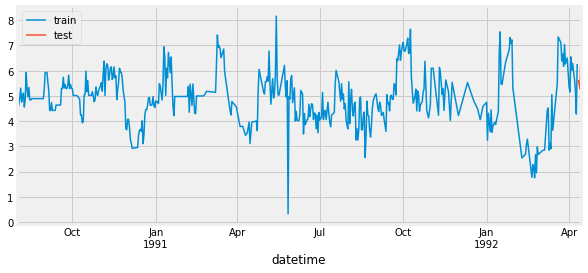

In [965]:
# Split data into train-test
# ==============================================================================
data_train = load.loc[:end_train, :]
data_test = load.loc[start_test:, :]

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(9, 4))
data_train["y"].plot(ax=ax, label="train")
data_test["y"].plot(ax=ax, label="test")
ax.legend();

#  Autocorrelation plots

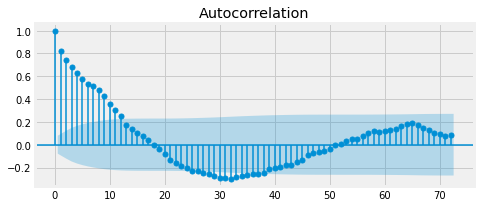

In [966]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data_train["y"], ax=ax, lags=72)
plt.show()

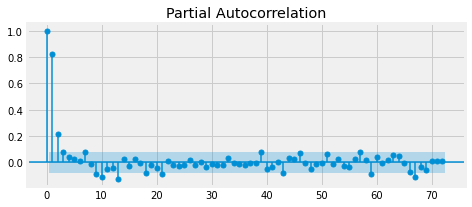

In [967]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data_train["y"], ax=ax, lags=72)
plt.show()

# RandomForest

In [968]:
exog_variables = list(data_train.columns.drop(["y", "Номер скважины"]))
print(exog_variables)

['Давление забойное', 'Активная мощность (ТМ)', 'Время работы (ТМ)', 'Газовый фактор рабочий (ТМ)', 'Давление забойное от Hд', 'Давление забойное от Pпр', 'Давление линейное (ТМ)', 'Давление на входе ЭЦН (ТМ)', 'Дебит газа (ТМ)', 'Дебит газа попутного', 'Дебит жидкости (ТМ)', 'Коэффициент мощности (ТМ)']


In [969]:
# Hyperparameter Grid search
# ==============================================================================
steps = 90
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=12,  # This value will be replaced in the grid search
)

lags_grid = [30]

param_grid = {"n_estimators": [120], "max_depth": [10]}

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=data_train["y"],
    exog=data_train[exog_variables],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=steps,
    refit=True,
    metric="mean_squared_error",
    initial_train_size=int(len(data_train) * 0.5),
    return_best=True,
    verbose=False,
)

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 120}
  Backtesting metric: 1.420179121594727



In [988]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(regressor=CatBoostRegressor(random_state=123), lags=30)

forecaster.fit(y=data_train["y"], exog=data_train[exog_variables])

Learning rate set to 0.037658
0:	learn: 1.0409033	total: 5.85ms	remaining: 5.84s
1:	learn: 1.0214037	total: 11.6ms	remaining: 5.8s
2:	learn: 1.0010607	total: 16.5ms	remaining: 5.5s
3:	learn: 0.9813821	total: 22.2ms	remaining: 5.54s
4:	learn: 0.9615071	total: 27.6ms	remaining: 5.49s
5:	learn: 0.9417892	total: 32.5ms	remaining: 5.38s
6:	learn: 0.9216843	total: 37.4ms	remaining: 5.3s
7:	learn: 0.9036962	total: 42.3ms	remaining: 5.25s
8:	learn: 0.8870912	total: 47ms	remaining: 5.17s
9:	learn: 0.8720856	total: 51.2ms	remaining: 5.07s
10:	learn: 0.8542782	total: 56ms	remaining: 5.04s
11:	learn: 0.8420230	total: 60.5ms	remaining: 4.98s
12:	learn: 0.8268644	total: 64.6ms	remaining: 4.91s
13:	learn: 0.8111474	total: 68.7ms	remaining: 4.84s
14:	learn: 0.7960333	total: 73ms	remaining: 4.79s
15:	learn: 0.7834871	total: 77.1ms	remaining: 4.74s
16:	learn: 0.7723895	total: 81.7ms	remaining: 4.72s
17:	learn: 0.7588970	total: 86.3ms	remaining: 4.71s
18:	learn: 0.7478960	total: 90.7ms	remaining: 4.68s
1

191:	learn: 0.2988294	total: 896ms	remaining: 3.77s
192:	learn: 0.2980628	total: 903ms	remaining: 3.77s
193:	learn: 0.2977261	total: 909ms	remaining: 3.78s
194:	learn: 0.2974072	total: 915ms	remaining: 3.78s
195:	learn: 0.2972069	total: 920ms	remaining: 3.77s
196:	learn: 0.2968160	total: 925ms	remaining: 3.77s
197:	learn: 0.2966194	total: 930ms	remaining: 3.77s
198:	learn: 0.2956527	total: 936ms	remaining: 3.77s
199:	learn: 0.2944680	total: 940ms	remaining: 3.76s
200:	learn: 0.2939106	total: 945ms	remaining: 3.75s
201:	learn: 0.2937018	total: 949ms	remaining: 3.75s
202:	learn: 0.2928534	total: 954ms	remaining: 3.74s
203:	learn: 0.2925492	total: 959ms	remaining: 3.74s
204:	learn: 0.2923221	total: 966ms	remaining: 3.75s
205:	learn: 0.2920008	total: 975ms	remaining: 3.76s
206:	learn: 0.2906630	total: 981ms	remaining: 3.76s
207:	learn: 0.2904653	total: 987ms	remaining: 3.76s
208:	learn: 0.2902869	total: 992ms	remaining: 3.75s
209:	learn: 0.2899831	total: 1s	remaining: 3.76s
210:	learn: 0.2

362:	learn: 0.1934219	total: 1.79s	remaining: 3.15s
363:	learn: 0.1927572	total: 1.8s	remaining: 3.15s
364:	learn: 0.1921766	total: 1.8s	remaining: 3.14s
365:	learn: 0.1918937	total: 1.81s	remaining: 3.14s
366:	learn: 0.1916230	total: 1.82s	remaining: 3.13s
367:	learn: 0.1911340	total: 1.82s	remaining: 3.13s
368:	learn: 0.1910128	total: 1.82s	remaining: 3.12s
369:	learn: 0.1904259	total: 1.83s	remaining: 3.11s
370:	learn: 0.1903080	total: 1.83s	remaining: 3.11s
371:	learn: 0.1900056	total: 1.84s	remaining: 3.1s
372:	learn: 0.1891981	total: 1.84s	remaining: 3.1s
373:	learn: 0.1890718	total: 1.85s	remaining: 3.09s
374:	learn: 0.1886913	total: 1.85s	remaining: 3.09s
375:	learn: 0.1882184	total: 1.86s	remaining: 3.08s
376:	learn: 0.1877429	total: 1.86s	remaining: 3.08s
377:	learn: 0.1869585	total: 1.87s	remaining: 3.07s
378:	learn: 0.1868395	total: 1.87s	remaining: 3.07s
379:	learn: 0.1863128	total: 1.88s	remaining: 3.06s
380:	learn: 0.1857468	total: 1.88s	remaining: 3.06s
381:	learn: 0.18

537:	learn: 0.1312979	total: 2.69s	remaining: 2.31s
538:	learn: 0.1309134	total: 2.7s	remaining: 2.31s
539:	learn: 0.1307493	total: 2.7s	remaining: 2.3s
540:	learn: 0.1307010	total: 2.71s	remaining: 2.3s
541:	learn: 0.1302213	total: 2.71s	remaining: 2.29s
542:	learn: 0.1300667	total: 2.72s	remaining: 2.29s
543:	learn: 0.1293398	total: 2.72s	remaining: 2.28s
544:	learn: 0.1290796	total: 2.73s	remaining: 2.28s
545:	learn: 0.1290341	total: 2.73s	remaining: 2.27s
546:	learn: 0.1286148	total: 2.74s	remaining: 2.27s
547:	learn: 0.1282873	total: 2.74s	remaining: 2.26s
548:	learn: 0.1281209	total: 2.75s	remaining: 2.26s
549:	learn: 0.1277032	total: 2.75s	remaining: 2.25s
550:	learn: 0.1273617	total: 2.75s	remaining: 2.25s
551:	learn: 0.1273243	total: 2.76s	remaining: 2.24s
552:	learn: 0.1268327	total: 2.77s	remaining: 2.23s
553:	learn: 0.1267968	total: 2.77s	remaining: 2.23s
554:	learn: 0.1264743	total: 2.77s	remaining: 2.22s
555:	learn: 0.1261916	total: 2.78s	remaining: 2.22s
556:	learn: 0.12

710:	learn: 0.0913223	total: 3.58s	remaining: 1.46s
711:	learn: 0.0911324	total: 3.59s	remaining: 1.45s
712:	learn: 0.0911052	total: 3.6s	remaining: 1.45s
713:	learn: 0.0908544	total: 3.6s	remaining: 1.44s
714:	learn: 0.0904187	total: 3.61s	remaining: 1.44s
715:	learn: 0.0903831	total: 3.61s	remaining: 1.43s
716:	learn: 0.0901761	total: 3.62s	remaining: 1.43s
717:	learn: 0.0901522	total: 3.62s	remaining: 1.42s
718:	learn: 0.0899063	total: 3.63s	remaining: 1.42s
719:	learn: 0.0896909	total: 3.63s	remaining: 1.41s
720:	learn: 0.0896642	total: 3.64s	remaining: 1.41s
721:	learn: 0.0894098	total: 3.65s	remaining: 1.4s
722:	learn: 0.0892440	total: 3.65s	remaining: 1.4s
723:	learn: 0.0888374	total: 3.65s	remaining: 1.39s
724:	learn: 0.0888100	total: 3.66s	remaining: 1.39s
725:	learn: 0.0886789	total: 3.67s	remaining: 1.38s
726:	learn: 0.0884046	total: 3.67s	remaining: 1.38s
727:	learn: 0.0883834	total: 3.68s	remaining: 1.37s
728:	learn: 0.0881740	total: 3.69s	remaining: 1.37s
729:	learn: 0.08

874:	learn: 0.0657726	total: 4.49s	remaining: 641ms
875:	learn: 0.0656769	total: 4.49s	remaining: 636ms
876:	learn: 0.0655911	total: 4.5s	remaining: 631ms
877:	learn: 0.0655588	total: 4.5s	remaining: 626ms
878:	learn: 0.0653912	total: 4.51s	remaining: 621ms
879:	learn: 0.0653649	total: 4.51s	remaining: 615ms
880:	learn: 0.0652842	total: 4.52s	remaining: 610ms
881:	learn: 0.0652095	total: 4.52s	remaining: 605ms
882:	learn: 0.0649927	total: 4.53s	remaining: 600ms
883:	learn: 0.0648714	total: 4.53s	remaining: 595ms
884:	learn: 0.0646810	total: 4.54s	remaining: 590ms
885:	learn: 0.0644611	total: 4.55s	remaining: 585ms
886:	learn: 0.0643514	total: 4.55s	remaining: 580ms
887:	learn: 0.0641962	total: 4.56s	remaining: 575ms
888:	learn: 0.0640147	total: 4.57s	remaining: 570ms
889:	learn: 0.0638733	total: 4.57s	remaining: 565ms
890:	learn: 0.0637029	total: 4.58s	remaining: 560ms
891:	learn: 0.0636307	total: 4.58s	remaining: 555ms
892:	learn: 0.0635313	total: 4.6s	remaining: 551ms
893:	learn: 0.0

In [989]:
# Predictions
# ==============================================================================
steps = 90

predictions = forecaster.predict(steps=steps, exog=data_train[exog_variables])

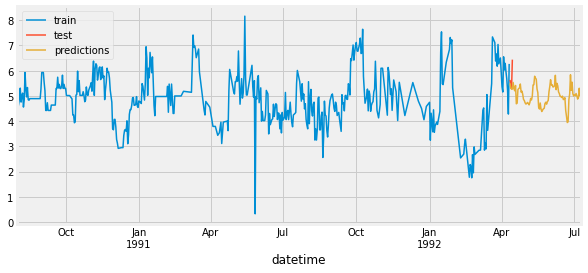

In [990]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train["y"].plot(ax=ax, label="train")
data_test["y"].plot(ax=ax, label="test")
predictions.plot(ax=ax, label="predictions")
ax.legend();

In [985]:
# Interactive plot of predictions
# ==============================================================================
data_plot = pd.DataFrame(
    {"train": data_train["y"], "test": data_test["y"], "prediction": predictions,}
)
data_plot.index.name = "date_time"

fig = px.line(
    data_frame=data_plot.reset_index(),
    x="date_time",
    y=data_plot.columns,
    title="Number of users",
    width=900,
    height=500,
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [991]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data_train["y"],
    exog=data_train[exog_variables],
    initial_train_size=90,
    fixed_train_size=False,
    steps=90,
    refit=True,
    metric="mean_squared_error",
    verbose=True,
)

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 90
Number of observations used for backtesting: 529
    Number of folds: 6
    Number of steps per fold: 90
    Last fold only includes 79 observations.

Data partition in fold: 0
    Training:   1990-08-01 00:00:00 -- 1990-10-29 00:00:00
    Validation: 1990-10-30 00:00:00 -- 1991-01-27 00:00:00
Data partition in fold: 1
    Training:   1990-08-01 00:00:00 -- 1991-01-27 00:00:00
    Validation: 1991-01-28 00:00:00 -- 1991-04-27 00:00:00
Data partition in fold: 2
    Training:   1990-08-01 00:00:00 -- 1991-04-27 00:00:00
    Validation: 1991-04-28 00:00:00 -- 1991-07-26 00:00:00
Data partition in fold: 3
    Training:   1990-08-01 00:00:00 -- 1991-07-26 00:00:00
    Validation: 1991-07-27 00:00:00 -- 1991-10-24 00:00:00
Data partition in fold: 4
    Training:   1990-08-01 00:00:00 -- 1991-10-24 00:00:00
    Validation: 1991-10-25 00:00:00 -- 1992-01-22 00:00:00
Data p

262:	learn: 0.0467809	total: 294ms	remaining: 823ms
263:	learn: 0.0464490	total: 295ms	remaining: 822ms
264:	learn: 0.0460543	total: 296ms	remaining: 821ms
265:	learn: 0.0456937	total: 297ms	remaining: 820ms
266:	learn: 0.0453453	total: 299ms	remaining: 820ms
267:	learn: 0.0449700	total: 300ms	remaining: 819ms
268:	learn: 0.0445207	total: 301ms	remaining: 818ms
269:	learn: 0.0441957	total: 302ms	remaining: 817ms
270:	learn: 0.0438761	total: 303ms	remaining: 816ms
271:	learn: 0.0434602	total: 305ms	remaining: 815ms
272:	learn: 0.0431291	total: 306ms	remaining: 814ms
273:	learn: 0.0427841	total: 307ms	remaining: 813ms
274:	learn: 0.0424758	total: 308ms	remaining: 812ms
275:	learn: 0.0421347	total: 309ms	remaining: 811ms
276:	learn: 0.0417288	total: 310ms	remaining: 809ms
277:	learn: 0.0413994	total: 311ms	remaining: 808ms
278:	learn: 0.0410537	total: 312ms	remaining: 807ms
279:	learn: 0.0407559	total: 314ms	remaining: 807ms
280:	learn: 0.0404945	total: 315ms	remaining: 806ms
281:	learn: 

420:	learn: 0.0150384	total: 463ms	remaining: 636ms
421:	learn: 0.0149413	total: 464ms	remaining: 636ms
422:	learn: 0.0148447	total: 465ms	remaining: 635ms
423:	learn: 0.0147423	total: 466ms	remaining: 634ms
424:	learn: 0.0146823	total: 467ms	remaining: 632ms
425:	learn: 0.0146231	total: 469ms	remaining: 632ms
426:	learn: 0.0145296	total: 470ms	remaining: 630ms
427:	learn: 0.0144095	total: 471ms	remaining: 629ms
428:	learn: 0.0142798	total: 472ms	remaining: 628ms
429:	learn: 0.0141854	total: 473ms	remaining: 627ms
430:	learn: 0.0140922	total: 474ms	remaining: 626ms
431:	learn: 0.0139909	total: 475ms	remaining: 625ms
432:	learn: 0.0139354	total: 477ms	remaining: 624ms
433:	learn: 0.0138214	total: 478ms	remaining: 623ms
434:	learn: 0.0137313	total: 479ms	remaining: 622ms
435:	learn: 0.0136086	total: 480ms	remaining: 621ms
436:	learn: 0.0135237	total: 481ms	remaining: 620ms
437:	learn: 0.0134114	total: 482ms	remaining: 619ms
438:	learn: 0.0133285	total: 484ms	remaining: 618ms
439:	learn: 

578:	learn: 0.0047900	total: 632ms	remaining: 459ms
579:	learn: 0.0047585	total: 634ms	remaining: 459ms
580:	learn: 0.0047258	total: 635ms	remaining: 458ms
581:	learn: 0.0046961	total: 636ms	remaining: 457ms
582:	learn: 0.0046655	total: 637ms	remaining: 456ms
583:	learn: 0.0046208	total: 638ms	remaining: 455ms
584:	learn: 0.0045909	total: 640ms	remaining: 454ms
585:	learn: 0.0045472	total: 641ms	remaining: 453ms
586:	learn: 0.0045179	total: 642ms	remaining: 452ms
587:	learn: 0.0044890	total: 643ms	remaining: 451ms
588:	learn: 0.0044466	total: 644ms	remaining: 450ms
589:	learn: 0.0044183	total: 646ms	remaining: 449ms
590:	learn: 0.0043904	total: 647ms	remaining: 448ms
591:	learn: 0.0043492	total: 648ms	remaining: 447ms
592:	learn: 0.0043219	total: 649ms	remaining: 446ms
593:	learn: 0.0042914	total: 650ms	remaining: 444ms
594:	learn: 0.0042567	total: 651ms	remaining: 443ms
595:	learn: 0.0042268	total: 652ms	remaining: 442ms
596:	learn: 0.0042036	total: 653ms	remaining: 441ms
597:	learn: 

829:	learn: 0.0009881	total: 971ms	remaining: 199ms
830:	learn: 0.0009825	total: 973ms	remaining: 198ms
831:	learn: 0.0009749	total: 974ms	remaining: 197ms
832:	learn: 0.0009677	total: 976ms	remaining: 196ms
833:	learn: 0.0009599	total: 977ms	remaining: 194ms
834:	learn: 0.0009535	total: 979ms	remaining: 193ms
835:	learn: 0.0009459	total: 980ms	remaining: 192ms
836:	learn: 0.0009402	total: 981ms	remaining: 191ms
837:	learn: 0.0009328	total: 983ms	remaining: 190ms
838:	learn: 0.0009260	total: 984ms	remaining: 189ms
839:	learn: 0.0009183	total: 987ms	remaining: 188ms
840:	learn: 0.0009117	total: 989ms	remaining: 187ms
841:	learn: 0.0009051	total: 991ms	remaining: 186ms
842:	learn: 0.0008985	total: 992ms	remaining: 185ms
843:	learn: 0.0008932	total: 993ms	remaining: 184ms
844:	learn: 0.0008868	total: 994ms	remaining: 182ms
845:	learn: 0.0008805	total: 995ms	remaining: 181ms
846:	learn: 0.0008752	total: 997ms	remaining: 180ms
847:	learn: 0.0008702	total: 998ms	remaining: 179ms
848:	learn: 

Learning rate set to 0.030339
0:	learn: 0.8395391	total: 3.13ms	remaining: 3.12s
1:	learn: 0.8270781	total: 6.09ms	remaining: 3.04s
2:	learn: 0.8170106	total: 9.35ms	remaining: 3.1s
3:	learn: 0.8046824	total: 12.2ms	remaining: 3.04s
4:	learn: 0.7905857	total: 14.7ms	remaining: 2.93s
5:	learn: 0.7820682	total: 17.5ms	remaining: 2.89s
6:	learn: 0.7704380	total: 21.2ms	remaining: 3.01s
7:	learn: 0.7574914	total: 24ms	remaining: 2.98s
8:	learn: 0.7488354	total: 26.4ms	remaining: 2.9s
9:	learn: 0.7376863	total: 28.7ms	remaining: 2.84s
10:	learn: 0.7262000	total: 31ms	remaining: 2.78s
11:	learn: 0.7158958	total: 33.2ms	remaining: 2.73s
12:	learn: 0.7066064	total: 36.4ms	remaining: 2.76s
13:	learn: 0.6961374	total: 40.9ms	remaining: 2.88s
14:	learn: 0.6846276	total: 43.6ms	remaining: 2.86s
15:	learn: 0.6740319	total: 45.9ms	remaining: 2.82s
16:	learn: 0.6648167	total: 48.5ms	remaining: 2.8s
17:	learn: 0.6541705	total: 51.8ms	remaining: 2.82s
18:	learn: 0.6444155	total: 54.9ms	remaining: 2.83s

187:	learn: 0.1268445	total: 517ms	remaining: 2.23s
188:	learn: 0.1260415	total: 521ms	remaining: 2.23s
189:	learn: 0.1252069	total: 523ms	remaining: 2.23s
190:	learn: 0.1249323	total: 526ms	remaining: 2.23s
191:	learn: 0.1240810	total: 531ms	remaining: 2.23s
192:	learn: 0.1230051	total: 534ms	remaining: 2.23s
193:	learn: 0.1228039	total: 537ms	remaining: 2.23s
194:	learn: 0.1219404	total: 540ms	remaining: 2.23s
195:	learn: 0.1210320	total: 544ms	remaining: 2.23s
196:	learn: 0.1203032	total: 547ms	remaining: 2.23s
197:	learn: 0.1194948	total: 550ms	remaining: 2.23s
198:	learn: 0.1192658	total: 553ms	remaining: 2.22s
199:	learn: 0.1186551	total: 555ms	remaining: 2.22s
200:	learn: 0.1184632	total: 558ms	remaining: 2.22s
201:	learn: 0.1176363	total: 562ms	remaining: 2.22s
202:	learn: 0.1167941	total: 565ms	remaining: 2.22s
203:	learn: 0.1164047	total: 568ms	remaining: 2.21s
204:	learn: 0.1156309	total: 570ms	remaining: 2.21s
205:	learn: 0.1150317	total: 574ms	remaining: 2.21s
206:	learn: 

351:	learn: 0.0558705	total: 1.04s	remaining: 1.91s
352:	learn: 0.0557938	total: 1.04s	remaining: 1.91s
353:	learn: 0.0554547	total: 1.04s	remaining: 1.9s
354:	learn: 0.0552778	total: 1.04s	remaining: 1.9s
355:	learn: 0.0550963	total: 1.05s	remaining: 1.9s
356:	learn: 0.0550416	total: 1.05s	remaining: 1.89s
357:	learn: 0.0548365	total: 1.05s	remaining: 1.89s
358:	learn: 0.0547436	total: 1.06s	remaining: 1.89s
359:	learn: 0.0546759	total: 1.06s	remaining: 1.89s
360:	learn: 0.0544929	total: 1.06s	remaining: 1.88s
361:	learn: 0.0541728	total: 1.07s	remaining: 1.88s
362:	learn: 0.0539905	total: 1.07s	remaining: 1.88s
363:	learn: 0.0536188	total: 1.07s	remaining: 1.87s
364:	learn: 0.0535145	total: 1.07s	remaining: 1.87s
365:	learn: 0.0531566	total: 1.08s	remaining: 1.87s
366:	learn: 0.0529296	total: 1.08s	remaining: 1.86s
367:	learn: 0.0526240	total: 1.08s	remaining: 1.86s
368:	learn: 0.0523530	total: 1.08s	remaining: 1.85s
369:	learn: 0.0519944	total: 1.09s	remaining: 1.85s
370:	learn: 0.0

531:	learn: 0.0265359	total: 1.55s	remaining: 1.37s
532:	learn: 0.0263432	total: 1.56s	remaining: 1.36s
533:	learn: 0.0261637	total: 1.56s	remaining: 1.36s
534:	learn: 0.0260947	total: 1.56s	remaining: 1.36s
535:	learn: 0.0260648	total: 1.56s	remaining: 1.35s
536:	learn: 0.0258629	total: 1.56s	remaining: 1.35s
537:	learn: 0.0258129	total: 1.57s	remaining: 1.35s
538:	learn: 0.0256578	total: 1.57s	remaining: 1.34s
539:	learn: 0.0255882	total: 1.57s	remaining: 1.34s
540:	learn: 0.0254419	total: 1.57s	remaining: 1.34s
541:	learn: 0.0254007	total: 1.58s	remaining: 1.33s
542:	learn: 0.0253612	total: 1.58s	remaining: 1.33s
543:	learn: 0.0252998	total: 1.58s	remaining: 1.33s
544:	learn: 0.0252560	total: 1.59s	remaining: 1.32s
545:	learn: 0.0251582	total: 1.59s	remaining: 1.32s
546:	learn: 0.0250144	total: 1.59s	remaining: 1.32s
547:	learn: 0.0248994	total: 1.59s	remaining: 1.31s
548:	learn: 0.0248643	total: 1.6s	remaining: 1.31s
549:	learn: 0.0248222	total: 1.6s	remaining: 1.31s
550:	learn: 0.

710:	learn: 0.0128816	total: 2.09s	remaining: 851ms
711:	learn: 0.0128066	total: 2.1s	remaining: 848ms
712:	learn: 0.0127496	total: 2.1s	remaining: 844ms
713:	learn: 0.0126715	total: 2.1s	remaining: 841ms
714:	learn: 0.0126046	total: 2.1s	remaining: 838ms
715:	learn: 0.0125753	total: 2.11s	remaining: 835ms
716:	learn: 0.0124945	total: 2.11s	remaining: 833ms
717:	learn: 0.0124225	total: 2.11s	remaining: 830ms
718:	learn: 0.0123632	total: 2.12s	remaining: 828ms
719:	learn: 0.0122836	total: 2.12s	remaining: 825ms
720:	learn: 0.0122220	total: 2.13s	remaining: 823ms
721:	learn: 0.0121862	total: 2.13s	remaining: 819ms
722:	learn: 0.0121029	total: 2.13s	remaining: 816ms
723:	learn: 0.0120409	total: 2.13s	remaining: 813ms
724:	learn: 0.0119713	total: 2.14s	remaining: 811ms
725:	learn: 0.0119408	total: 2.14s	remaining: 808ms
726:	learn: 0.0118767	total: 2.14s	remaining: 805ms
727:	learn: 0.0118078	total: 2.15s	remaining: 802ms
728:	learn: 0.0117516	total: 2.15s	remaining: 799ms
729:	learn: 0.01

870:	learn: 0.0066228	total: 2.61s	remaining: 387ms
871:	learn: 0.0066049	total: 2.62s	remaining: 384ms
872:	learn: 0.0065667	total: 2.62s	remaining: 381ms
873:	learn: 0.0065313	total: 2.62s	remaining: 378ms
874:	learn: 0.0065176	total: 2.63s	remaining: 375ms
875:	learn: 0.0065008	total: 2.63s	remaining: 372ms
876:	learn: 0.0064768	total: 2.63s	remaining: 369ms
877:	learn: 0.0064488	total: 2.63s	remaining: 366ms
878:	learn: 0.0064215	total: 2.64s	remaining: 363ms
879:	learn: 0.0063839	total: 2.64s	remaining: 360ms
880:	learn: 0.0063586	total: 2.65s	remaining: 357ms
881:	learn: 0.0063454	total: 2.65s	remaining: 354ms
882:	learn: 0.0063166	total: 2.65s	remaining: 351ms
883:	learn: 0.0063000	total: 2.65s	remaining: 348ms
884:	learn: 0.0062910	total: 2.66s	remaining: 346ms
885:	learn: 0.0062537	total: 2.66s	remaining: 343ms
886:	learn: 0.0062154	total: 2.67s	remaining: 340ms
887:	learn: 0.0061842	total: 2.67s	remaining: 337ms
888:	learn: 0.0061728	total: 2.67s	remaining: 334ms
889:	learn: 

39:	learn: 0.4655523	total: 171ms	remaining: 4.11s
40:	learn: 0.4594605	total: 174ms	remaining: 4.08s
41:	learn: 0.4532498	total: 178ms	remaining: 4.05s
42:	learn: 0.4476516	total: 182ms	remaining: 4.04s
43:	learn: 0.4435991	total: 186ms	remaining: 4.04s
44:	learn: 0.4382899	total: 189ms	remaining: 4.02s
45:	learn: 0.4329155	total: 193ms	remaining: 4s
46:	learn: 0.4281097	total: 199ms	remaining: 4.03s
47:	learn: 0.4231572	total: 203ms	remaining: 4.03s
48:	learn: 0.4182820	total: 207ms	remaining: 4.02s
49:	learn: 0.4121639	total: 212ms	remaining: 4.02s
50:	learn: 0.4069698	total: 216ms	remaining: 4.01s
51:	learn: 0.4026713	total: 219ms	remaining: 3.99s
52:	learn: 0.3977526	total: 223ms	remaining: 3.98s
53:	learn: 0.3939059	total: 229ms	remaining: 4.01s
54:	learn: 0.3901948	total: 233ms	remaining: 4s
55:	learn: 0.3855203	total: 237ms	remaining: 4s
56:	learn: 0.3810166	total: 242ms	remaining: 4.01s
57:	learn: 0.3774284	total: 246ms	remaining: 4s
58:	learn: 0.3736053	total: 250ms	remaining

228:	learn: 0.1471866	total: 1.06s	remaining: 3.56s
229:	learn: 0.1468719	total: 1.06s	remaining: 3.55s
230:	learn: 0.1465769	total: 1.06s	remaining: 3.55s
231:	learn: 0.1460445	total: 1.07s	remaining: 3.54s
232:	learn: 0.1453821	total: 1.08s	remaining: 3.54s
233:	learn: 0.1446180	total: 1.08s	remaining: 3.54s
234:	learn: 0.1443439	total: 1.08s	remaining: 3.53s
235:	learn: 0.1439974	total: 1.09s	remaining: 3.52s
236:	learn: 0.1438657	total: 1.09s	remaining: 3.52s
237:	learn: 0.1433739	total: 1.1s	remaining: 3.51s
238:	learn: 0.1432208	total: 1.1s	remaining: 3.5s
239:	learn: 0.1431182	total: 1.1s	remaining: 3.5s
240:	learn: 0.1429848	total: 1.11s	remaining: 3.49s
241:	learn: 0.1420645	total: 1.11s	remaining: 3.49s
242:	learn: 0.1417069	total: 1.12s	remaining: 3.48s
243:	learn: 0.1412088	total: 1.12s	remaining: 3.48s
244:	learn: 0.1410268	total: 1.13s	remaining: 3.47s
245:	learn: 0.1407641	total: 1.13s	remaining: 3.46s
246:	learn: 0.1402758	total: 1.13s	remaining: 3.46s
247:	learn: 0.139

416:	learn: 0.0845080	total: 1.94s	remaining: 2.72s
417:	learn: 0.0843604	total: 1.95s	remaining: 2.72s
418:	learn: 0.0839259	total: 1.95s	remaining: 2.71s
419:	learn: 0.0835325	total: 1.96s	remaining: 2.7s
420:	learn: 0.0832970	total: 1.96s	remaining: 2.7s
421:	learn: 0.0832192	total: 1.97s	remaining: 2.69s
422:	learn: 0.0831698	total: 1.97s	remaining: 2.69s
423:	learn: 0.0828748	total: 1.97s	remaining: 2.68s
424:	learn: 0.0827763	total: 1.98s	remaining: 2.67s
425:	learn: 0.0826873	total: 1.98s	remaining: 2.67s
426:	learn: 0.0823549	total: 1.98s	remaining: 2.66s
427:	learn: 0.0821378	total: 1.99s	remaining: 2.66s
428:	learn: 0.0819691	total: 1.99s	remaining: 2.65s
429:	learn: 0.0816567	total: 2s	remaining: 2.65s
430:	learn: 0.0815933	total: 2s	remaining: 2.64s
431:	learn: 0.0813223	total: 2s	remaining: 2.63s
432:	learn: 0.0812684	total: 2.01s	remaining: 2.63s
433:	learn: 0.0809055	total: 2.01s	remaining: 2.62s
434:	learn: 0.0807765	total: 2.01s	remaining: 2.62s
435:	learn: 0.0803382	t

599:	learn: 0.0515854	total: 2.66s	remaining: 1.77s
600:	learn: 0.0513865	total: 2.66s	remaining: 1.77s
601:	learn: 0.0511332	total: 2.67s	remaining: 1.76s
602:	learn: 0.0508403	total: 2.67s	remaining: 1.76s
603:	learn: 0.0506266	total: 2.67s	remaining: 1.75s
604:	learn: 0.0505672	total: 2.68s	remaining: 1.75s
605:	learn: 0.0503305	total: 2.68s	remaining: 1.74s
606:	learn: 0.0502924	total: 2.69s	remaining: 1.74s
607:	learn: 0.0500568	total: 2.69s	remaining: 1.73s
608:	learn: 0.0499902	total: 2.69s	remaining: 1.73s
609:	learn: 0.0497339	total: 2.7s	remaining: 1.73s
610:	learn: 0.0495113	total: 2.71s	remaining: 1.72s
611:	learn: 0.0494235	total: 2.71s	remaining: 1.72s
612:	learn: 0.0491981	total: 2.72s	remaining: 1.72s
613:	learn: 0.0490349	total: 2.72s	remaining: 1.71s
614:	learn: 0.0489113	total: 2.73s	remaining: 1.71s
615:	learn: 0.0486952	total: 2.73s	remaining: 1.7s
616:	learn: 0.0485490	total: 2.74s	remaining: 1.7s
617:	learn: 0.0484379	total: 2.74s	remaining: 1.69s
618:	learn: 0.0

770:	learn: 0.0319418	total: 3.35s	remaining: 996ms
771:	learn: 0.0318705	total: 3.35s	remaining: 991ms
772:	learn: 0.0318263	total: 3.36s	remaining: 986ms
773:	learn: 0.0317582	total: 3.36s	remaining: 982ms
774:	learn: 0.0315819	total: 3.37s	remaining: 977ms
775:	learn: 0.0315027	total: 3.37s	remaining: 972ms
776:	learn: 0.0314725	total: 3.37s	remaining: 968ms
777:	learn: 0.0314537	total: 3.37s	remaining: 963ms
778:	learn: 0.0313793	total: 3.38s	remaining: 958ms
779:	learn: 0.0313216	total: 3.38s	remaining: 954ms
780:	learn: 0.0312128	total: 3.39s	remaining: 950ms
781:	learn: 0.0311516	total: 3.39s	remaining: 945ms
782:	learn: 0.0311369	total: 3.39s	remaining: 940ms
783:	learn: 0.0309868	total: 3.4s	remaining: 936ms
784:	learn: 0.0309623	total: 3.4s	remaining: 931ms
785:	learn: 0.0308139	total: 3.4s	remaining: 927ms
786:	learn: 0.0307890	total: 3.41s	remaining: 922ms
787:	learn: 0.0307197	total: 3.41s	remaining: 917ms
788:	learn: 0.0306727	total: 3.41s	remaining: 913ms
789:	learn: 0.0

966:	learn: 0.0194483	total: 4.07s	remaining: 139ms
967:	learn: 0.0193804	total: 4.07s	remaining: 135ms
968:	learn: 0.0193150	total: 4.07s	remaining: 130ms
969:	learn: 0.0192499	total: 4.08s	remaining: 126ms
970:	learn: 0.0192329	total: 4.08s	remaining: 122ms
971:	learn: 0.0191846	total: 4.08s	remaining: 118ms
972:	learn: 0.0191636	total: 4.09s	remaining: 113ms
973:	learn: 0.0191524	total: 4.09s	remaining: 109ms
974:	learn: 0.0190737	total: 4.09s	remaining: 105ms
975:	learn: 0.0190507	total: 4.1s	remaining: 101ms
976:	learn: 0.0190287	total: 4.11s	remaining: 96.7ms
977:	learn: 0.0189722	total: 4.11s	remaining: 92.5ms
978:	learn: 0.0189579	total: 4.11s	remaining: 88.2ms
979:	learn: 0.0189458	total: 4.12s	remaining: 84ms
980:	learn: 0.0188578	total: 4.12s	remaining: 79.8ms
981:	learn: 0.0188154	total: 4.12s	remaining: 75.6ms
982:	learn: 0.0187869	total: 4.13s	remaining: 71.4ms
983:	learn: 0.0187698	total: 4.13s	remaining: 67.1ms
984:	learn: 0.0187472	total: 4.13s	remaining: 62.9ms
985:	l

141:	learn: 0.2730591	total: 717ms	remaining: 4.33s
142:	learn: 0.2721561	total: 722ms	remaining: 4.33s
143:	learn: 0.2713763	total: 727ms	remaining: 4.32s
144:	learn: 0.2704267	total: 732ms	remaining: 4.32s
145:	learn: 0.2699699	total: 738ms	remaining: 4.32s
146:	learn: 0.2697351	total: 743ms	remaining: 4.31s
147:	learn: 0.2679204	total: 747ms	remaining: 4.3s
148:	learn: 0.2666853	total: 751ms	remaining: 4.29s
149:	learn: 0.2651930	total: 756ms	remaining: 4.29s
150:	learn: 0.2639309	total: 761ms	remaining: 4.28s
151:	learn: 0.2629375	total: 766ms	remaining: 4.27s
152:	learn: 0.2620802	total: 770ms	remaining: 4.26s
153:	learn: 0.2608305	total: 774ms	remaining: 4.25s
154:	learn: 0.2604167	total: 778ms	remaining: 4.24s
155:	learn: 0.2593357	total: 783ms	remaining: 4.24s
156:	learn: 0.2580933	total: 789ms	remaining: 4.24s
157:	learn: 0.2562421	total: 794ms	remaining: 4.23s
158:	learn: 0.2556032	total: 799ms	remaining: 4.22s
159:	learn: 0.2540032	total: 804ms	remaining: 4.22s
160:	learn: 0

323:	learn: 0.1390961	total: 1.62s	remaining: 3.38s
324:	learn: 0.1386764	total: 1.62s	remaining: 3.37s
325:	learn: 0.1384624	total: 1.63s	remaining: 3.37s
326:	learn: 0.1379396	total: 1.63s	remaining: 3.36s
327:	learn: 0.1370544	total: 1.64s	remaining: 3.35s
328:	learn: 0.1364022	total: 1.64s	remaining: 3.35s
329:	learn: 0.1358346	total: 1.65s	remaining: 3.34s
330:	learn: 0.1353176	total: 1.65s	remaining: 3.33s
331:	learn: 0.1345691	total: 1.65s	remaining: 3.33s
332:	learn: 0.1344069	total: 1.66s	remaining: 3.33s
333:	learn: 0.1338329	total: 1.66s	remaining: 3.32s
334:	learn: 0.1328882	total: 1.67s	remaining: 3.31s
335:	learn: 0.1319257	total: 1.67s	remaining: 3.31s
336:	learn: 0.1317136	total: 1.68s	remaining: 3.3s
337:	learn: 0.1312122	total: 1.68s	remaining: 3.29s
338:	learn: 0.1306254	total: 1.69s	remaining: 3.29s
339:	learn: 0.1301250	total: 1.69s	remaining: 3.28s
340:	learn: 0.1299089	total: 1.7s	remaining: 3.28s
341:	learn: 0.1292911	total: 1.7s	remaining: 3.27s
342:	learn: 0.1

482:	learn: 0.0883316	total: 2.34s	remaining: 2.5s
483:	learn: 0.0882487	total: 2.34s	remaining: 2.5s
484:	learn: 0.0879648	total: 2.35s	remaining: 2.49s
485:	learn: 0.0878348	total: 2.35s	remaining: 2.49s
486:	learn: 0.0873767	total: 2.36s	remaining: 2.48s
487:	learn: 0.0872912	total: 2.36s	remaining: 2.48s
488:	learn: 0.0870890	total: 2.37s	remaining: 2.48s
489:	learn: 0.0868878	total: 2.37s	remaining: 2.47s
490:	learn: 0.0866807	total: 2.38s	remaining: 2.46s
491:	learn: 0.0863451	total: 2.38s	remaining: 2.46s
492:	learn: 0.0861922	total: 2.39s	remaining: 2.45s
493:	learn: 0.0859186	total: 2.39s	remaining: 2.45s
494:	learn: 0.0856178	total: 2.4s	remaining: 2.44s
495:	learn: 0.0855566	total: 2.4s	remaining: 2.44s
496:	learn: 0.0852148	total: 2.4s	remaining: 2.43s
497:	learn: 0.0848372	total: 2.41s	remaining: 2.43s
498:	learn: 0.0846658	total: 2.41s	remaining: 2.42s
499:	learn: 0.0845948	total: 2.42s	remaining: 2.42s
500:	learn: 0.0845655	total: 2.42s	remaining: 2.41s
501:	learn: 0.084

669:	learn: 0.0568616	total: 3.23s	remaining: 1.59s
670:	learn: 0.0566779	total: 3.23s	remaining: 1.58s
671:	learn: 0.0565505	total: 3.24s	remaining: 1.58s
672:	learn: 0.0563897	total: 3.24s	remaining: 1.57s
673:	learn: 0.0562233	total: 3.25s	remaining: 1.57s
674:	learn: 0.0561899	total: 3.25s	remaining: 1.56s
675:	learn: 0.0561594	total: 3.26s	remaining: 1.56s
676:	learn: 0.0559696	total: 3.26s	remaining: 1.56s
677:	learn: 0.0559206	total: 3.27s	remaining: 1.55s
678:	learn: 0.0557550	total: 3.27s	remaining: 1.55s
679:	learn: 0.0556689	total: 3.28s	remaining: 1.54s
680:	learn: 0.0555587	total: 3.28s	remaining: 1.54s
681:	learn: 0.0555144	total: 3.29s	remaining: 1.53s
682:	learn: 0.0553399	total: 3.29s	remaining: 1.53s
683:	learn: 0.0551499	total: 3.29s	remaining: 1.52s
684:	learn: 0.0549256	total: 3.3s	remaining: 1.52s
685:	learn: 0.0548626	total: 3.3s	remaining: 1.51s
686:	learn: 0.0546686	total: 3.31s	remaining: 1.51s
687:	learn: 0.0544784	total: 3.31s	remaining: 1.5s
688:	learn: 0.0

861:	learn: 0.0365584	total: 4.12s	remaining: 659ms
862:	learn: 0.0364584	total: 4.12s	remaining: 654ms
863:	learn: 0.0364068	total: 4.13s	remaining: 649ms
864:	learn: 0.0363270	total: 4.13s	remaining: 645ms
865:	learn: 0.0362177	total: 4.13s	remaining: 640ms
866:	learn: 0.0361398	total: 4.14s	remaining: 635ms
867:	learn: 0.0360581	total: 4.14s	remaining: 630ms
868:	learn: 0.0359828	total: 4.15s	remaining: 625ms
869:	learn: 0.0358627	total: 4.15s	remaining: 621ms
870:	learn: 0.0357777	total: 4.16s	remaining: 616ms
871:	learn: 0.0357271	total: 4.16s	remaining: 611ms
872:	learn: 0.0356890	total: 4.17s	remaining: 606ms
873:	learn: 0.0355823	total: 4.17s	remaining: 601ms
874:	learn: 0.0355081	total: 4.17s	remaining: 597ms
875:	learn: 0.0354405	total: 4.18s	remaining: 592ms
876:	learn: 0.0353496	total: 4.18s	remaining: 587ms
877:	learn: 0.0352230	total: 4.19s	remaining: 582ms
878:	learn: 0.0351167	total: 4.19s	remaining: 577ms
879:	learn: 0.0350304	total: 4.2s	remaining: 572ms
880:	learn: 0

31:	learn: 0.5776148	total: 174ms	remaining: 5.25s
32:	learn: 0.5702047	total: 179ms	remaining: 5.25s
33:	learn: 0.5642942	total: 186ms	remaining: 5.27s
34:	learn: 0.5575689	total: 191ms	remaining: 5.26s
35:	learn: 0.5513968	total: 196ms	remaining: 5.25s
36:	learn: 0.5454596	total: 203ms	remaining: 5.27s
37:	learn: 0.5401623	total: 207ms	remaining: 5.25s
38:	learn: 0.5343848	total: 212ms	remaining: 5.22s
39:	learn: 0.5274733	total: 217ms	remaining: 5.21s
40:	learn: 0.5212860	total: 222ms	remaining: 5.2s
41:	learn: 0.5156185	total: 226ms	remaining: 5.16s
42:	learn: 0.5096817	total: 231ms	remaining: 5.14s
43:	learn: 0.5043795	total: 237ms	remaining: 5.14s
44:	learn: 0.4993525	total: 242ms	remaining: 5.13s
45:	learn: 0.4948253	total: 247ms	remaining: 5.13s
46:	learn: 0.4900603	total: 252ms	remaining: 5.11s
47:	learn: 0.4855497	total: 256ms	remaining: 5.08s
48:	learn: 0.4808970	total: 260ms	remaining: 5.05s
49:	learn: 0.4759208	total: 267ms	remaining: 5.08s
50:	learn: 0.4716440	total: 272m

202:	learn: 0.2440799	total: 1.07s	remaining: 4.2s
203:	learn: 0.2427408	total: 1.07s	remaining: 4.19s
204:	learn: 0.2418051	total: 1.08s	remaining: 4.19s
205:	learn: 0.2403897	total: 1.08s	remaining: 4.18s
206:	learn: 0.2388962	total: 1.09s	remaining: 4.18s
207:	learn: 0.2386843	total: 1.1s	remaining: 4.17s
208:	learn: 0.2375616	total: 1.1s	remaining: 4.17s
209:	learn: 0.2370861	total: 1.11s	remaining: 4.16s
210:	learn: 0.2359632	total: 1.11s	remaining: 4.15s
211:	learn: 0.2352672	total: 1.11s	remaining: 4.14s
212:	learn: 0.2340043	total: 1.12s	remaining: 4.13s
213:	learn: 0.2331597	total: 1.12s	remaining: 4.13s
214:	learn: 0.2329474	total: 1.13s	remaining: 4.12s
215:	learn: 0.2316772	total: 1.13s	remaining: 4.12s
216:	learn: 0.2315112	total: 1.14s	remaining: 4.11s
217:	learn: 0.2313395	total: 1.14s	remaining: 4.1s
218:	learn: 0.2311905	total: 1.15s	remaining: 4.09s
219:	learn: 0.2309678	total: 1.15s	remaining: 4.08s
220:	learn: 0.2306444	total: 1.16s	remaining: 4.08s
221:	learn: 0.23

376:	learn: 0.1341205	total: 1.97s	remaining: 3.26s
377:	learn: 0.1337045	total: 1.98s	remaining: 3.25s
378:	learn: 0.1330498	total: 1.98s	remaining: 3.25s
379:	learn: 0.1326403	total: 1.99s	remaining: 3.24s
380:	learn: 0.1320566	total: 1.99s	remaining: 3.24s
381:	learn: 0.1317084	total: 2s	remaining: 3.23s
382:	learn: 0.1312704	total: 2s	remaining: 3.23s
383:	learn: 0.1305339	total: 2.01s	remaining: 3.22s
384:	learn: 0.1300060	total: 2.01s	remaining: 3.22s
385:	learn: 0.1294666	total: 2.02s	remaining: 3.21s
386:	learn: 0.1291099	total: 2.02s	remaining: 3.21s
387:	learn: 0.1285640	total: 2.03s	remaining: 3.2s
388:	learn: 0.1280324	total: 2.03s	remaining: 3.19s
389:	learn: 0.1275599	total: 2.04s	remaining: 3.19s
390:	learn: 0.1271891	total: 2.04s	remaining: 3.18s
391:	learn: 0.1269724	total: 2.05s	remaining: 3.17s
392:	learn: 0.1264638	total: 2.05s	remaining: 3.17s
393:	learn: 0.1260871	total: 2.06s	remaining: 3.16s
394:	learn: 0.1255714	total: 2.06s	remaining: 3.16s
395:	learn: 0.12539

554:	learn: 0.0809144	total: 2.86s	remaining: 2.3s
555:	learn: 0.0806043	total: 2.87s	remaining: 2.29s
556:	learn: 0.0804178	total: 2.87s	remaining: 2.29s
557:	learn: 0.0801691	total: 2.88s	remaining: 2.28s
558:	learn: 0.0800763	total: 2.89s	remaining: 2.28s
559:	learn: 0.0798489	total: 2.89s	remaining: 2.27s
560:	learn: 0.0796292	total: 2.9s	remaining: 2.27s
561:	learn: 0.0794408	total: 2.9s	remaining: 2.26s
562:	learn: 0.0792641	total: 2.91s	remaining: 2.26s
563:	learn: 0.0792135	total: 2.92s	remaining: 2.26s
564:	learn: 0.0790063	total: 2.93s	remaining: 2.25s
565:	learn: 0.0788155	total: 2.93s	remaining: 2.25s
566:	learn: 0.0785321	total: 2.94s	remaining: 2.25s
567:	learn: 0.0782877	total: 2.94s	remaining: 2.24s
568:	learn: 0.0778906	total: 2.95s	remaining: 2.23s
569:	learn: 0.0778464	total: 2.96s	remaining: 2.23s
570:	learn: 0.0775779	total: 2.96s	remaining: 2.22s
571:	learn: 0.0772981	total: 2.97s	remaining: 2.22s
572:	learn: 0.0771876	total: 2.97s	remaining: 2.21s
573:	learn: 0.0

723:	learn: 0.0541906	total: 3.76s	remaining: 1.43s
724:	learn: 0.0540349	total: 3.77s	remaining: 1.43s
725:	learn: 0.0539000	total: 3.77s	remaining: 1.42s
726:	learn: 0.0537610	total: 3.78s	remaining: 1.42s
727:	learn: 0.0536728	total: 3.79s	remaining: 1.41s
728:	learn: 0.0535125	total: 3.79s	remaining: 1.41s
729:	learn: 0.0533223	total: 3.8s	remaining: 1.4s
730:	learn: 0.0531961	total: 3.8s	remaining: 1.4s
731:	learn: 0.0531272	total: 3.81s	remaining: 1.39s
732:	learn: 0.0530170	total: 3.81s	remaining: 1.39s
733:	learn: 0.0527996	total: 3.82s	remaining: 1.38s
734:	learn: 0.0526006	total: 3.82s	remaining: 1.38s
735:	learn: 0.0524179	total: 3.83s	remaining: 1.37s
736:	learn: 0.0523730	total: 3.83s	remaining: 1.37s
737:	learn: 0.0522702	total: 3.84s	remaining: 1.36s
738:	learn: 0.0522286	total: 3.84s	remaining: 1.36s
739:	learn: 0.0521067	total: 3.85s	remaining: 1.35s
740:	learn: 0.0519742	total: 3.85s	remaining: 1.35s
741:	learn: 0.0518756	total: 3.86s	remaining: 1.34s
742:	learn: 0.05

893:	learn: 0.0371447	total: 4.66s	remaining: 552ms
894:	learn: 0.0369679	total: 4.66s	remaining: 547ms
895:	learn: 0.0368533	total: 4.67s	remaining: 542ms
896:	learn: 0.0367612	total: 4.67s	remaining: 537ms
897:	learn: 0.0366509	total: 4.68s	remaining: 532ms
898:	learn: 0.0366133	total: 4.69s	remaining: 526ms
899:	learn: 0.0365348	total: 4.69s	remaining: 521ms
900:	learn: 0.0364562	total: 4.7s	remaining: 516ms
901:	learn: 0.0363818	total: 4.7s	remaining: 511ms
902:	learn: 0.0363342	total: 4.71s	remaining: 506ms
903:	learn: 0.0362788	total: 4.71s	remaining: 500ms
904:	learn: 0.0361885	total: 4.71s	remaining: 495ms
905:	learn: 0.0360930	total: 4.72s	remaining: 490ms
906:	learn: 0.0360483	total: 4.72s	remaining: 484ms
907:	learn: 0.0358972	total: 4.73s	remaining: 479ms
908:	learn: 0.0357650	total: 4.74s	remaining: 474ms
909:	learn: 0.0357215	total: 4.74s	remaining: 469ms
910:	learn: 0.0355932	total: 4.75s	remaining: 464ms
911:	learn: 0.0354974	total: 4.75s	remaining: 458ms
912:	learn: 0.

60:	learn: 0.4306822	total: 385ms	remaining: 5.92s
61:	learn: 0.4283587	total: 391ms	remaining: 5.91s
62:	learn: 0.4252117	total: 398ms	remaining: 5.92s
63:	learn: 0.4228124	total: 405ms	remaining: 5.92s
64:	learn: 0.4196771	total: 411ms	remaining: 5.91s
65:	learn: 0.4173490	total: 418ms	remaining: 5.91s
66:	learn: 0.4147599	total: 422ms	remaining: 5.88s
67:	learn: 0.4130133	total: 428ms	remaining: 5.87s
68:	learn: 0.4101139	total: 433ms	remaining: 5.84s
69:	learn: 0.4084903	total: 437ms	remaining: 5.81s
70:	learn: 0.4058655	total: 442ms	remaining: 5.78s
71:	learn: 0.4034836	total: 446ms	remaining: 5.75s
72:	learn: 0.4012631	total: 451ms	remaining: 5.72s
73:	learn: 0.3985368	total: 456ms	remaining: 5.71s
74:	learn: 0.3965767	total: 463ms	remaining: 5.71s
75:	learn: 0.3942947	total: 469ms	remaining: 5.7s
76:	learn: 0.3927786	total: 475ms	remaining: 5.7s
77:	learn: 0.3903598	total: 480ms	remaining: 5.68s
78:	learn: 0.3874962	total: 485ms	remaining: 5.66s
79:	learn: 0.3853769	total: 492ms

250:	learn: 0.2317440	total: 1.46s	remaining: 4.36s
251:	learn: 0.2314818	total: 1.47s	remaining: 4.35s
252:	learn: 0.2304433	total: 1.47s	remaining: 4.34s
253:	learn: 0.2297014	total: 1.48s	remaining: 4.33s
254:	learn: 0.2295228	total: 1.48s	remaining: 4.33s
255:	learn: 0.2288676	total: 1.49s	remaining: 4.32s
256:	learn: 0.2280878	total: 1.49s	remaining: 4.32s
257:	learn: 0.2279807	total: 1.5s	remaining: 4.31s
258:	learn: 0.2278713	total: 1.5s	remaining: 4.3s
259:	learn: 0.2269110	total: 1.51s	remaining: 4.29s
260:	learn: 0.2258662	total: 1.51s	remaining: 4.29s
261:	learn: 0.2249770	total: 1.52s	remaining: 4.28s
262:	learn: 0.2247465	total: 1.52s	remaining: 4.27s
263:	learn: 0.2242172	total: 1.53s	remaining: 4.26s
264:	learn: 0.2233872	total: 1.53s	remaining: 4.25s
265:	learn: 0.2223514	total: 1.54s	remaining: 4.24s
266:	learn: 0.2214339	total: 1.54s	remaining: 4.24s
267:	learn: 0.2207340	total: 1.55s	remaining: 4.23s
268:	learn: 0.2206063	total: 1.55s	remaining: 4.22s
269:	learn: 0.2

414:	learn: 0.1458928	total: 2.36s	remaining: 3.33s
415:	learn: 0.1453716	total: 2.36s	remaining: 3.32s
416:	learn: 0.1449217	total: 2.37s	remaining: 3.31s
417:	learn: 0.1448333	total: 2.37s	remaining: 3.31s
418:	learn: 0.1442481	total: 2.38s	remaining: 3.3s
419:	learn: 0.1438836	total: 2.39s	remaining: 3.29s
420:	learn: 0.1432697	total: 2.39s	remaining: 3.29s
421:	learn: 0.1427491	total: 2.4s	remaining: 3.28s
422:	learn: 0.1421593	total: 2.4s	remaining: 3.28s
423:	learn: 0.1420825	total: 2.41s	remaining: 3.27s
424:	learn: 0.1416855	total: 2.41s	remaining: 3.26s
425:	learn: 0.1410739	total: 2.42s	remaining: 3.26s
426:	learn: 0.1407090	total: 2.42s	remaining: 3.25s
427:	learn: 0.1402631	total: 2.43s	remaining: 3.24s
428:	learn: 0.1398597	total: 2.43s	remaining: 3.23s
429:	learn: 0.1397423	total: 2.44s	remaining: 3.23s
430:	learn: 0.1392288	total: 2.44s	remaining: 3.22s
431:	learn: 0.1389802	total: 2.45s	remaining: 3.22s
432:	learn: 0.1386231	total: 2.45s	remaining: 3.21s
433:	learn: 0.1

581:	learn: 0.0938880	total: 3.28s	remaining: 2.35s
582:	learn: 0.0935781	total: 3.28s	remaining: 2.35s
583:	learn: 0.0933509	total: 3.29s	remaining: 2.34s
584:	learn: 0.0930377	total: 3.29s	remaining: 2.34s
585:	learn: 0.0927729	total: 3.3s	remaining: 2.33s
586:	learn: 0.0924981	total: 3.31s	remaining: 2.33s
587:	learn: 0.0924594	total: 3.31s	remaining: 2.32s
588:	learn: 0.0921895	total: 3.32s	remaining: 2.31s
589:	learn: 0.0921274	total: 3.32s	remaining: 2.31s
590:	learn: 0.0919836	total: 3.33s	remaining: 2.3s
591:	learn: 0.0916462	total: 3.33s	remaining: 2.3s
592:	learn: 0.0913976	total: 3.34s	remaining: 2.29s
593:	learn: 0.0911173	total: 3.34s	remaining: 2.29s
594:	learn: 0.0908169	total: 3.35s	remaining: 2.28s
595:	learn: 0.0906780	total: 3.35s	remaining: 2.27s
596:	learn: 0.0904158	total: 3.36s	remaining: 2.27s
597:	learn: 0.0901900	total: 3.36s	remaining: 2.26s
598:	learn: 0.0899929	total: 3.37s	remaining: 2.25s
599:	learn: 0.0898146	total: 3.38s	remaining: 2.25s
600:	learn: 0.0

741:	learn: 0.0663909	total: 4.17s	remaining: 1.45s
742:	learn: 0.0662341	total: 4.17s	remaining: 1.44s
743:	learn: 0.0661804	total: 4.18s	remaining: 1.44s
744:	learn: 0.0661283	total: 4.18s	remaining: 1.43s
745:	learn: 0.0660590	total: 4.19s	remaining: 1.43s
746:	learn: 0.0659544	total: 4.2s	remaining: 1.42s
747:	learn: 0.0659019	total: 4.2s	remaining: 1.42s
748:	learn: 0.0657263	total: 4.21s	remaining: 1.41s
749:	learn: 0.0655254	total: 4.21s	remaining: 1.41s
750:	learn: 0.0653972	total: 4.22s	remaining: 1.4s
751:	learn: 0.0652155	total: 4.22s	remaining: 1.39s
752:	learn: 0.0649744	total: 4.23s	remaining: 1.39s
753:	learn: 0.0649246	total: 4.24s	remaining: 1.38s
754:	learn: 0.0647316	total: 4.25s	remaining: 1.38s
755:	learn: 0.0646186	total: 4.25s	remaining: 1.37s
756:	learn: 0.0644498	total: 4.25s	remaining: 1.36s
757:	learn: 0.0642249	total: 4.26s	remaining: 1.36s
758:	learn: 0.0641254	total: 4.26s	remaining: 1.35s
759:	learn: 0.0640006	total: 4.27s	remaining: 1.35s
760:	learn: 0.0

905:	learn: 0.0472149	total: 5.07s	remaining: 526ms
906:	learn: 0.0470993	total: 5.08s	remaining: 521ms
907:	learn: 0.0470030	total: 5.08s	remaining: 515ms
908:	learn: 0.0468947	total: 5.09s	remaining: 509ms
909:	learn: 0.0467527	total: 5.09s	remaining: 504ms
910:	learn: 0.0466316	total: 5.1s	remaining: 498ms
911:	learn: 0.0464796	total: 5.11s	remaining: 493ms
912:	learn: 0.0463182	total: 5.11s	remaining: 487ms
913:	learn: 0.0462176	total: 5.12s	remaining: 482ms
914:	learn: 0.0460827	total: 5.13s	remaining: 476ms
915:	learn: 0.0459738	total: 5.13s	remaining: 471ms
916:	learn: 0.0459283	total: 5.14s	remaining: 465ms
917:	learn: 0.0457811	total: 5.14s	remaining: 459ms
918:	learn: 0.0456881	total: 5.15s	remaining: 454ms
919:	learn: 0.0456319	total: 5.15s	remaining: 448ms
920:	learn: 0.0455417	total: 5.16s	remaining: 443ms
921:	learn: 0.0454343	total: 5.17s	remaining: 437ms
922:	learn: 0.0453779	total: 5.17s	remaining: 432ms
923:	learn: 0.0453243	total: 5.18s	remaining: 426ms
924:	learn: 0

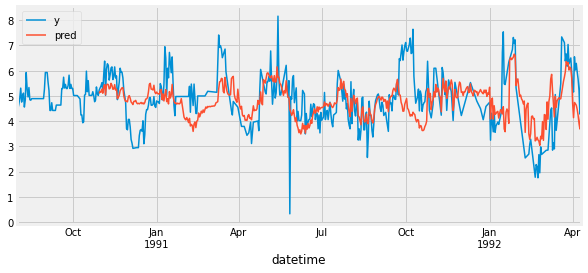

In [992]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train["y"].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend();

## Let's try to GridSearch for all wells with CatBoost

Сделаем GridSearch для всех скважин

In [876]:
%%time
data0 = wells[104].copy()

data_train = data0.loc[:end_train, :]
exog_variables = list(data_train.columns.drop(["y", "Номер скважины"]))

steps = 90
forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_state=123, silent=True), lags=12
)

lags_grid = [70, 80, 50]

param_grid = {
    "n_estimators": [700, 500, 1000],
    "max_depth": [3],
    "learning_rate": [0.1],
}

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=data_train["y"],
    exog=data_train[exog_variables],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=steps,
    refit=False,
    metric="mean_squared_error",
    initial_train_size=int(len(data_train) - 90),
    return_best=True,
    verbose=False,
)

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:13<00:00,  4.50s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.7059019544563794

Wall time: 14.9 s


In [878]:
def get_best_params(wells):
    for i in tqdm(range(len(wells))):
        print(f"Starting well №{i}")
        data = wells[i].copy()

        data_train = data.loc[:end_train, :]
        exog_variables = list(data_train.columns.drop(["y", "Номер скважины"]))

        steps = 90
        forecaster = ForecasterAutoreg(
            regressor=CatBoostRegressor(random_state=123, silent=True), lags=12
        )

        lags_grid = [75, 80]

        param_grid = {
            "n_estimators": [700, 500, 1000],
            "max_depth": [3, 5],
            "learning_rate": [0.1],
        }

        results_grid = grid_search_forecaster(
            forecaster=forecaster,
            y=data_train["y"],
            exog=data_train[exog_variables],
            param_grid=param_grid,
            lags_grid=lags_grid,
            steps=steps,
            refit=False,
            metric="mean_squared_error",
            initial_train_size=int(len(data_train) - 90),
            return_best=True,
            verbose=False,
        )
        best_param_dict[i] = {
            "n_lags": len(results_grid.iloc[0, :].lags),
            "params": results_grid.iloc[0, :].params,
        }

    return best_param_dict

In [879]:
best_params = get_best_params(wells)

  0%|          | 0/106 [00:00<?, ?it/s]

Starting well №0
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:33<00:00, 16.89s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 6.14604476962098

Starting well №1
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:39<00:00, 19.95s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 3.3525191441567097

Starting well №2
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 11.449675945604481

Starting well №3
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.45s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 2.8502848546997295

Starting well №4
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.26761163328779264

Starting well №5
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:41<00:00, 20.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 9.825926291974435

Starting well №6
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.25s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.8292376438138398

Starting well №7
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.12s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 9.195357144663623

Starting well №8
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.18s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 1.921979474976527

Starting well №9
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 85.26731975216894

Starting well №10
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.359424850147439

Starting well №11
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2.7985625053553536

Starting well №12
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.84s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.25683886207658235

Starting well №13
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.52s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 5.9039980937811345

Starting well №14
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.91s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 0.6311195205610576

Starting well №15
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.45s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 10.23705029050476

Starting well №16
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.74s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 0.5646918835151662

Starting well №17
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:41<00:00, 20.54s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 33.11059879897536

Starting well №18
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:39<00:00, 19.80s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 6.138833356462659

Starting well №19
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 0.4660316236070383

Starting well №20
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.36s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.04286212370351852

Starting well №21
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.61s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 4.420968748134888

Starting well №22
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 4.730863904175996

Starting well №23
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.48s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 3.7193297792292004

Starting well №24
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:39<00:00, 19.74s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 7.205782815925767

Starting well №25
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.15s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 17.498573220663303

Starting well №26
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.24s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.3738867319128796

Starting well №27
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.75s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 17.950668219981942

Starting well №28
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.07s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 0.9627163523672477

Starting well №29
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.88s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.646095287759061

Starting well №30
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.98s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 5.490606988645092

Starting well №31
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.90s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 0.3877324312491633

Starting well №32
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 6.668831898228603

Starting well №33
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.35s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2.4838013450814946

Starting well №34
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.60s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2.4606444041491686

Starting well №35
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.27s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 2.7478181192046542

Starting well №36
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 0.5593323593641908

Starting well №37
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.87s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 23.001691253120004

Starting well №38
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.61s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 43.465016025316835

Starting well №39
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.70s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 3.2934291463570737

Starting well №40
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.84s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 5.325562083843261

Starting well №41
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.75s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 11.385221383741658

Starting well №42
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.97s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 7.401444924672776

Starting well №43
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 4.526543607509282

Starting well №44
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.1124900749582816

Starting well №45
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.23s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 0.45333814078838675

Starting well №46
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.67s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 3.5530066141461885

Starting well №47
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.76s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 1.451975659518848

Starting well №48
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.16s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.8920232814200062

Starting well №49
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 9.331335100980041

Starting well №50
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.90s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 1.7029265095811537

Starting well №51
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.55s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 0.49132428204527134

Starting well №52
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.74s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2.288883226728125

Starting well №53
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.18s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.29949054742627784

Starting well №54
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.39s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 4.828716149084811

Starting well №55
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.64s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 0.11059807456116424

Starting well №56
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.61s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 5.194816902591909

Starting well №57
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.80s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 4.882972383199303

Starting well №58
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.04s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 2.818499045908912

Starting well №59
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.29s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 1.9111139889078002

Starting well №60
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.93s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 28.08030255053451

Starting well №61
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 5.732084130613691

Starting well №62
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.63s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 26.302854294271256

Starting well №63
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.73s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 35.95223928718882

Starting well №64
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.72s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 23.23252245530367

Starting well №65
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.72s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 15.758547821278146

Starting well №66
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.40s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 7.470955288376606

Starting well №67
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.88s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 7.5674769569227625

Starting well №68
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.77s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 17.323200138375576

Starting well №69
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.12s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 12.54541498471675

Starting well №70
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.91s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.6131905727381421

Starting well №71
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.40s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 20.258173786559787

Starting well №72
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.87s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 7.487571240002751

Starting well №73
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.99s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 11.431199491522873

Starting well №74
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.42s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 24.548514632661206

Starting well №75
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.70s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 24.037904117303743

Starting well №76
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:33<00:00, 16.63s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 0.22534926423200177

Starting well №77
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.5843084225870734

Starting well №78
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.26s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 5.511324692731088

Starting well №79
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.43s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 1.5839952753732676

Starting well №80
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.96s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 3.03982438099682

Starting well №81
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.40s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 0.9123881062853774

Starting well №82
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.52s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 5.814367228180587

Starting well №83
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.72s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 1.753360069419089

Starting well №84
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 0.14917882195566345

Starting well №85
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.73s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 37.99001843915822

Starting well №86
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.23s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 1.7062606788880308

Starting well №87
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:43<00:00, 21.94s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 2.0475913678566

Starting well №88
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 7.231180340650895

Starting well №89
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.40s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.9755413427974227

Starting well №90
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.23s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.14097644286353275

Starting well №91
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:41<00:00, 20.79s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.7446488253807176

Starting well №92
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:45<00:00, 22.68s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.5546013307181574

Starting well №93
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.48s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 4.223860149741393

Starting well №94
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.39s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 2.8314414388026936

Starting well №95
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.46s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 2.005763891211887

Starting well №96
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.37s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
  Backtesting metric: 3.3803632926158973

Starting well №97
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.91s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 3.6502683536175784

Starting well №98
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 9.114348504835913

Starting well №99
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.08s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
  Backtesting metric: 1.8434857368241886

Starting well №100
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.95s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 88.16149704134557

Starting well №101
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.18s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 0.46526983593327337

Starting well №102
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.64s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.3235840516589441

Starting well №103
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:36<00:00, 18.26s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 28.89098137542816

Starting well №104
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.54s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.7059019544563794

Starting well №105
Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.46079126637883255



In [880]:
import json

with open("best_param_grid.json", "w") as fp:
    json.dump(best_params, fp)

## Predict for each well

In [941]:
all_predictions = pd.DataFrame()

In [927]:
i = 0
data = wells[i].copy()
data_train = data.loc[:end_train, :]

exog_variables = list(data_train.columns.drop(["y", "Номер скважины"]))

forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(**best_params[0]["params"], silent=True),
    lags=best_params[i]["n_lags"],
)

forecaster.fit(y=data_train["y"], exog=data_train[exog_variables])

steps = 90

predictions = pd.DataFrame()
predictions["forecast"] = forecaster.predict(
    steps=steps, exog=data_train[exog_variables]
)
predictions["Номер скважины"] = i
predictions["datetime"] = predictions.index

predictions = predictions[["datetime", "forecast", "Номер скважины"]]

all_predictions = pd.concat(
    [all_predictions, predictions], ignore_index=False, sort=False
)

In [942]:
def get_predictions(wells_dict, params_dict):
    all_predictions = pd.DataFrame()
    for i in tqdm(range(len(wells))):
        print(f"Predition well №{i}")

        data = wells[i].copy()
        data_train = data.loc[:end_train, :]

        exog_variables = list(data_train.columns.drop(["y", "Номер скважины"]))

        forecaster = ForecasterAutoreg(
            regressor=CatBoostRegressor(**best_params[i]["params"], silent=True),
            lags=best_params[i]["n_lags"],
        )

        forecaster.fit(y=data_train["y"], exog=data_train[exog_variables])

        steps = 90

        predictions = pd.DataFrame()
        predictions["forecast"] = forecaster.predict(
            steps=steps, exog=data_train[exog_variables]
        )
        predictions["Номер скважины"] = i
        predictions["datetime"] = predictions.index

        predictions = predictions[["datetime", "forecast", "Номер скважины"]]

        all_predictions = pd.concat(
            [all_predictions, predictions], ignore_index=False, sort=False
        )

    return all_predictions

In [943]:
well_predictions = get_predictions(wells, best_params)

  0%|          | 0/106 [00:00<?, ?it/s]

Predition well №0
Predition well №1
Predition well №2
Predition well №3
Predition well №4
Predition well №5
Predition well №6
Predition well №7
Predition well №8
Predition well №9
Predition well №10
Predition well №11
Predition well №12
Predition well №13
Predition well №14
Predition well №15
Predition well №16
Predition well №17
Predition well №18
Predition well №19
Predition well №20
Predition well №21
Predition well №22
Predition well №23
Predition well №24
Predition well №25
Predition well №26
Predition well №27
Predition well №28
Predition well №29
Predition well №30
Predition well №31
Predition well №32
Predition well №33
Predition well №34
Predition well №35
Predition well №36
Predition well №37
Predition well №38
Predition well №39
Predition well №40
Predition well №41
Predition well №42
Predition well №43
Predition well №44
Predition well №45
Predition well №46
Predition well №47
Predition well №48
Predition well №49
Predition well №50
Predition well №51
Predition well №52
Pre

In [945]:
well_predictions.to_csv("CatBoost_forecast.csv", index=False, encoding="utf=8")

In [944]:
well_predictions

,datetime,forecast,Номер скважины
1992-04-11,1992-04-11,12.016538,0
1992-04-12,1992-04-12,12.508334,0
1992-04-13,1992-04-13,14.401298,0
1992-04-14,1992-04-14,15.946103,0
1992-04-15,1992-04-15,16.005767,0
...,...,...,...
1992-07-05,1992-07-05,8.915855,105
1992-07-06,1992-07-06,9.078176,105
1992-07-07,1992-07-07,8.795453,105
1992-07-08,1992-07-08,8.890089,105
